# RoboGarden Machine Learning Capstone Project: Facial Recognition
***

This file build upon the initial analysis of the facial recognition database by analyzing the data with a neural network. 

## Import Libraries

In [3]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib
import glob
from sklearn import cluster
import seaborn as sns

from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn.model_selection import train_test_split
import itertools

#early stopping plugin
# https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM

from livelossplot import PlotLossesKeras

Using TensorFlow backend.


## Load the data set: 
This dataset is a processed version of the YouTube Faces Dataset, that basically contained short videos of celebrities that are publicly available and were downloaded from YouTube. There are multiple videos of each celebrity (up to 6 videos per celebrity). I've cropped the original videos around the faces, plus kept only consecutive frames of up to 240 frames for each original video. This is done also for reasons of disk space, but mainly to make the dataset easier to use.
The dataset is available here: https://www.kaggle.com/selfishgene/youtube-faces-with-facial-keypoints

References:
Lior Wolf, Tal Hassner and Itay Maoz 
Face Recognition in Unconstrained Videos with Matched Background Similarity. 
IEEE Conf. on Computer Vision and Pattern Recognition (CVPR), 2011. (pdf)

2D and 3D keypoints, from the following paper: 
<br>Adrian Bulat and Georgios Tzimiropoulos. 
How far are we from solving the 2D & 3D Face Alignment problem? 
(and a dataset of 230,000 3D facial landmarks), arxiv, 2017. (pdf)

In [4]:
videoDF = pd.read_csv('youtube_faces_with_keypoints_large.csv')
videoDF.head(5)

,videoID,personName,imageHeight,imageWidth,videoDuration,averageFaceSize,numVideosForPerson
0,Alison_Lohman_0,Alison_Lohman,228.0,213.0,240.0,90.150000,6.0
1,Alison_Lohman_1,Alison_Lohman,248.0,201.0,79.0,108.417722,6.0
2,Alison_Lohman_2,Alison_Lohman,335.0,308.0,136.0,122.161765,6.0
3,Alison_Lohman_3,Alison_Lohman,151.0,110.0,53.0,58.000000,6.0
4,Alison_Lohman_4,Alison_Lohman,236.0,228.0,147.0,91.680272,6.0


## Import the file containing the target columns as prepared in the first analysis file.  

Don't worry, I've included it as well!
The file contains one line per still image in eachvideo.  the actualName column represents the encoded label names for use in analysis. We split using get_dummies later.

In [5]:
dfCompare = pd.read_csv("export_dataframe.csv")

In [6]:
dfCompare.head()

,videoIDexpanded,frameNum,actualName
0,Alison_Lohman_0,0,18
1,Alison_Lohman_0,1,18
2,Alison_Lohman_0,2,18
3,Alison_Lohman_0,3,18
4,Alison_Lohman_0,4,18


In [7]:
dfCompare.count()

videoIDexpanded    155560
frameNum           155560
actualName         155560
dtype: int64

## Dataset Overview:

In [8]:
#Number of unique people
categories = len(videoDF.personName.unique())
nameList = videoDF.personName.unique()
numList = np.arange(0,categories)
print("There are", categories, 'unique people in the dataset')
#print(nameList)
#print(numList),print(len(numList))

There are 374 unique people in the dataset


## Locate the Video Files for Use

Glob is an extension of Python that assigns a filepath to each file in a given directory so that it can be called by the program.

In [9]:
npzFilesFullPath = glob.glob('*.npz')

# remove the .npz file extension
videoIDs = [x.split('/')[-1].split('.')[0] for x in npzFilesFullPath]

# create a dictionary to call the videos, key is the file name in teh dataframe, value is the filepath
fullPaths = {}
for videoID, fullPath in zip(videoIDs, npzFilesFullPath):
    fullPaths[videoID] = fullPath

In [10]:
# Columns in the .npz files
#    videoFile = np.load(fullPaths[videoID])
#    colorImages = videoFile['colorImages']
#    boundingBox = videoFile['boundingBox']
#    landmarks2D = videoFile['landmarks2D']
#    landmarks3D = videoFile['landmarks3D']


In [15]:
# define which points need to be connected with a line
jawPoints          = [ 0,17]
rigthEyebrowPoints = [17,22]
leftEyebrowPoints  = [22,27]
noseRidgePoints    = [27,31]
noseBasePoints     = [31,36]
rightEyePoints     = [36,42]
leftEyePoints      = [42,48]
outerMouthPoints   = [48,60]
innerMouthPoints   = [60,68]

listOfAllConnectedPoints = [jawPoints,rigthEyebrowPoints,leftEyebrowPoints,
                            noseRidgePoints,noseBasePoints,
                            rightEyePoints,leftEyePoints,outerMouthPoints,innerMouthPoints]

## Initiate Exploratory Data Analysis on the landmark points to compare images

Collect all of the 2D and 3D shapes from all frames from all videos and save to a single numpy array matrix

In [11]:
totalNumberOfFrames = int(videoDF['videoDuration'].sum())
print('Total number of frames in dataset: ',totalNumberOfFrames)

#Initialize arrarys for the landmark points for each frame in the dataset
landmarks2D_all = np.zeros((68,2,int(totalNumberOfFrames)))
landmarks3D_all = np.zeros((68,3,int(totalNumberOfFrames)))

shapeIndToVideoID = {} # dictionary for later useage
endInd = 0

# Add the frames to the arrays
for i, videoID in enumerate(videoDF['videoID']):
    
    # load video
    videoFile = np.load(fullPaths[videoID])
    #print(videoFile)
    landmarks2D = videoFile['landmarks2D']
    landmarks3D = videoFile['landmarks3D']
    
    startInd = endInd
    endInd   = startInd + landmarks2D.shape[2]

    # store in one big array
    landmarks2D_all[:,:,startInd:endInd] = landmarks2D
    landmarks3D_all[:,:,startInd:endInd] = landmarks3D
    
    # make sure we keep track of the mapping to the original video and frame
    for videoFrameInd, shapeInd in enumerate(range(startInd,endInd)):
        shapeIndToVideoID[shapeInd] = (videoID, videoFrameInd)
    

Total number of frames in dataset:  155560


## Normalize the landmarks so they can be compared

In [12]:
# center the shapes around zero
# i.e. such that for each frame the mean x,y,z coordinates will be zero
# or in math terms: Xc = X - mean(X), Yc = Y - mean(Y), Zc = Z - mean(Z)
landmarks2D_centered = np.zeros(landmarks2D_all.shape)
landmarks2D_centered = landmarks2D_all - np.tile(landmarks2D_all.mean(axis=0),[68,1,1])

landmarks3D_centered = np.zeros(landmarks3D_all.shape)
landmarks3D_centered = landmarks3D_all - np.tile(landmarks3D_all.mean(axis=0),[68,1,1])

# normalize the shapes such that they have the same scale
# i.e. such that for each frame the mean euclidian distance from the shape center will be one
# or in math terms: mean( sqrt(dX^2 + dY^2 + dZ^2) ) = 1 
landmarks2D_normlized = np.zeros(landmarks2D_all.shape)
landmarks2D_normlized = landmarks2D_centered / np.tile(np.sqrt((landmarks2D_centered**2).sum(axis=1)).mean(axis=0), [68,2,1])

landmarks3D_normlized = np.zeros(landmarks3D_all.shape)
landmarks3D_normlized = landmarks3D_centered / np.tile(np.sqrt((landmarks3D_centered**2).sum(axis=1)).mean(axis=0), [68,3,1])

## Visualize the normalizations

Text(0.5, 1.0, 'Normlized Shapes')

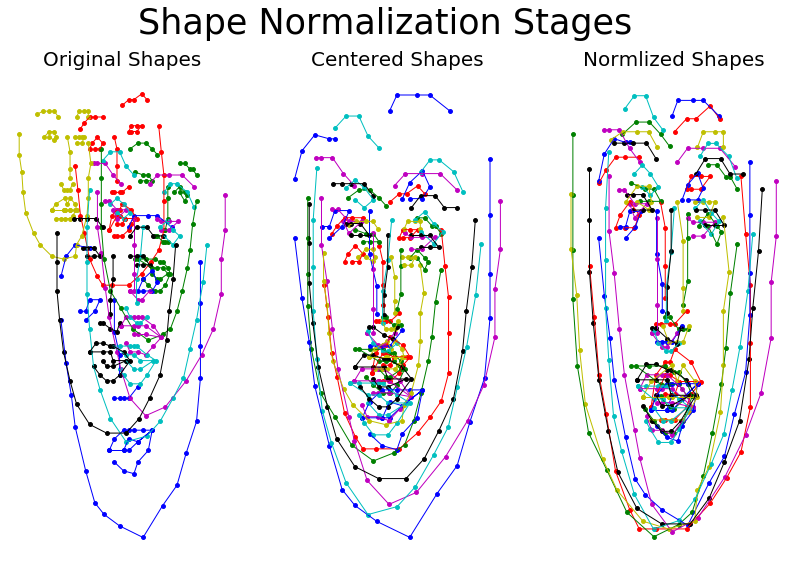

In [16]:
#%% check the 2D normalization and verify that everything is as expected
# select random several frames to be used as test cases
np.random.seed(2)

listOfShapeColors = ['r','g','b','m','y','c','k']
numShapesToPresent = len(listOfShapeColors)
listOfShapeInds = np.random.choice(range(int(totalNumberOfFrames)),size=numShapesToPresent,replace=False)

#plt.close('all') (not sure what this line is for, closes the plot windows, I suppose if you have in a different IDE)

plt.figure(figsize=(14,9))
plt.suptitle('Shape Normalization Stages',fontsize=35) # main figure box setup and title

plt.subplot(1,3,1)
for k,shapeInd in enumerate(listOfShapeInds):
    plt.scatter(landmarks2D_all[:,0,shapeInd], -landmarks2D_all[:,1,shapeInd], s=15, c=listOfShapeColors[k])
    for conPts in listOfAllConnectedPoints:
        xPts =  landmarks2D_all[conPts[0]:conPts[-1],0,shapeInd]
        yPts = -landmarks2D_all[conPts[0]:conPts[-1],1,shapeInd]
        plt.plot(xPts,yPts,c=listOfShapeColors[k],lw=1)
plt.axis('off'); 
plt.title('Original Shapes', fontsize=20)

plt.subplot(1,3,2)
for k,shapeInd in enumerate(listOfShapeInds):
    plt.scatter(landmarks2D_centered[:,0,shapeInd], -landmarks2D_centered[:,1,shapeInd], s=15, c=listOfShapeColors[k])
    for conPts in listOfAllConnectedPoints:
        xPts =  landmarks2D_centered[conPts[0]:conPts[-1],0,shapeInd]
        yPts = -landmarks2D_centered[conPts[0]:conPts[-1],1,shapeInd]
        plt.plot(xPts,yPts,c=listOfShapeColors[k],lw=1)
plt.axis('off'); plt.title('Centered Shapes', fontsize=20)

plt.subplot(1,3,3)
for k,shapeInd in enumerate(listOfShapeInds):
    plt.scatter(landmarks2D_normlized[:,0,shapeInd], -landmarks2D_normlized[:,1,shapeInd], s=15, c=listOfShapeColors[k])
    for conPts in listOfAllConnectedPoints:
        xPts =  landmarks2D_normlized[conPts[0]:conPts[-1],0,shapeInd]
        yPts = -landmarks2D_normlized[conPts[0]:conPts[-1],1,shapeInd]
        plt.plot(xPts,yPts,c=listOfShapeColors[k],lw=1)
plt.axis('off'); plt.title('Normlized Shapes', fontsize=20)

# Prepare the Data into Feature and Target for a Neural Network 

We are going to use the landmarked points on each of the still frames for each video to create a model to recognize similar faces.The Landmark points transformaed into a single order of values will be our feature column, and the encoded person labels will be our target. 

A further investigation cold look at modelling the abaility to predict based on individual arrangemnts of different parts of the face by looking at a subset of the landmark points.

In [17]:
#%% cluster normalized shapes and show the cluster centers
normalizedShapesTable2D = np.reshape(landmarks2D_normlized, [68*2, landmarks2D_normlized.shape[2]]).T
normalizedShapesTable3D = np.reshape(landmarks3D_normlized, [68*3, landmarks3D_normlized.shape[2]]).T

In [18]:
nodes=68*3
print(nodes)

204


In [19]:
X2D = normalizedShapesTable2D
X3D = normalizedShapesTable3D

Our target is the labelled person for each still frame in the videos and we need to encode the categories.  
No further scaling is required, it has already been scaled.

In [20]:
y=pd.get_dummies(dfCompare['actualName']).values
y[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

### Create training and testing sets for the 2D and 3D landmarking points.  No further transformation or scaling is needed as the data is scaled and centered above.

In [26]:
X_train2D, X_test2D, y_train2D, y_test2D = train_test_split(X2D, y, test_size=0.25, random_state=0)

In [27]:
X_train3D, X_test3D, y_train3D, y_test3D = train_test_split(X3D, y, test_size=0.25, random_state=0)

In [28]:
#y_test=pd.DataFrame(y_test)
print(X_train.shape)
print(X_train3D.shape)
print(y_train.shape)
print(y_train3D.shape)

(116670, 136)
(116670, 204)
(116670, 374)
(116670, 374)


# Look for an Optimized NN

## Model 7 - the best model I achieved after quite some tweaking

In [97]:
model7 = Sequential() 
print(categories)

model7.add(Dense(units=136, activation='relu', kernel_initializer='uniform')) #input layer
model7.add(Dense(units=300, activation='relu', kernel_initializer='uniform'))
model7.add(Dropout(rate=0.15))
model7.add(Dense(units=490, activation='relu', kernel_initializer='uniform'))
model7.add(Dense(units=440, activation='relu', kernel_initializer='uniform'))
model7.add(Dense(units=380, activation='relu', kernel_initializer='uniform')) 
model7.add(Dense(units=categories, activation='softmax', kernel_initializer='uniform')) #output layer

model7.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

374


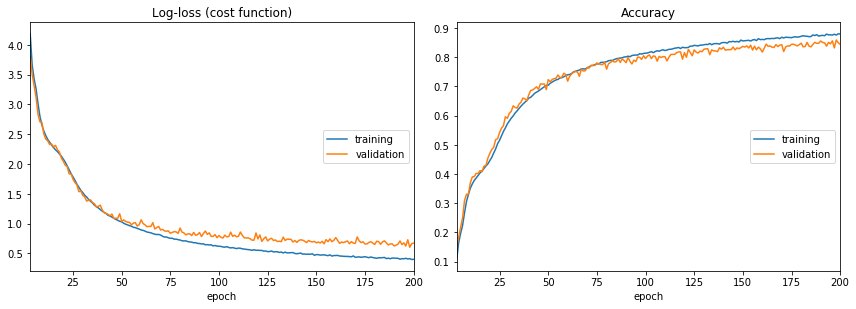

Log-loss (cost function):
training   (min:    0.398, max:    5.542, cur:    0.402)
validation (min:    0.604, max:    5.263, cur:    0.674)

Accuracy:
training   (min:    0.016, max:    0.881, cur:    0.880)
validation (min:    0.024, max:    0.859, cur:    0.844)

Epoch 00200: val_acc did not improve from 0.85924


In [98]:
#Add early stopping into this model so it doesn't run forever
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)
mc = ModelCheckpoint('best_model7.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model7.fit(X_train, y_train,
          batch_size = 110,
          epochs = 200,
          validation_data=(X_test2D, y_test2D),
          callbacks=[PlotLossesKeras(),es,mc],
          verbose=1)

In [30]:
saved_model2D = load_model('best_model7.h5')

y_pred2D = saved_model2D.predict(X_test2D).round(2)

loss2D, accuracy2D = saved_model2D.evaluate(X_test2D,y_test2D)
loss2D =loss2D.round(3)
accuracy2D = accuracy2D.round(3)
print(loss2D),print(accuracy2D)

38890/38890 [==============================] - 5s 123us/step
0.604
0.859


(None, None)

In [31]:
saved_model2D.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_53 (Dense)             (None, 136)               18632     
_________________________________________________________________
dense_54 (Dense)             (None, 300)               41100     
_________________________________________________________________
dropout_7 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_55 (Dense)             (None, 490)               147490    
_________________________________________________________________
dense_56 (Dense)             (None, 440)               216040    
_________________________________________________________________
dense_57 (Dense)             (None, 380)               167580    
_________________________________________________________________
dense_58 (Dense)             (None, 374)               142494    
Total para

## Can the accuracy be improved by using the 3D Landmark Masking?

## Multi-level perceptron on 3D Landmarks - a pretty good model after a little bit of tweaking

In [145]:
model3d4= Sequential()

model3d4.add(Dense(units=204, activation='relu', kernel_initializer='uniform')) #input layer

model3d4.add(Dense(units=400, activation='relu', kernel_initializer='uniform'))
model3d4.add(Dropout(rate=0.2))
model3d4.add(Dense(units=400, activation='relu', kernel_initializer='uniform'))
model3d4.add(Dropout(rate=0.2))
model3d4.add(Dense(units=390, activation='relu', kernel_initializer='uniform')) 
model3d4.add(Dense(units=380, activation='relu', kernel_initializer='uniform'))
model3d4.add(Dense(units=categories, activation='softmax', kernel_initializer='uniform')) #output layer

model3d4.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

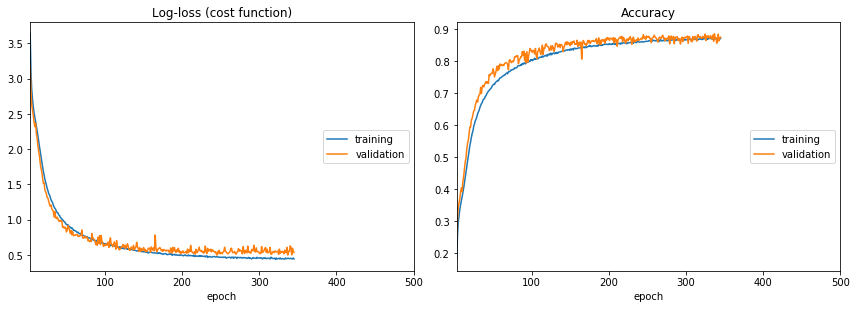

Log-loss (cost function):
training   (min:    0.434, max:    5.398, cur:    0.441)
validation (min:    0.496, max:    4.843, cur:    0.534)

Accuracy:
training   (min:    0.022, max:    0.872, cur:    0.872)
validation (min:    0.044, max:    0.886, cur:    0.875)

Epoch 00345: val_acc did not improve from 0.88581
Epoch 00345: early stopping


In [146]:
#Add early stopping into this model so it doesn't run forever
es = EarlyStopping(monitor='val_loss', mode='auto', verbose=1,patience=100)
mc = ModelCheckpoint('best_model_3D4.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

#Fit the model
model3d4.fit(X_train3D, y_train3D,
          batch_size = 110,
          epochs = 500,
          validation_data=(X_test3D, y_test3D),
          callbacks=[PlotLossesKeras(),es,mc],
          verbose=1)

In [32]:
saved_model = load_model('best_model_3D4.h5')

y_pred3d4 = saved_model.predict(X_test3D).round(2)

loss3D4, accuracy3D4 = saved_model.evaluate(X_test3D,y_test3D)
loss3D4 =loss3D4.round(3)
accuracy3D4 = accuracy3D4.round(3)
print(loss3D4),print(accuracy3D4)

38890/38890 [==============================] - 6s 142us/step
0.496
0.886


(None, None)

In [33]:
saved_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_104 (Dense)            (None, 204)               41820     
_________________________________________________________________
dense_105 (Dense)            (None, 400)               82000     
_________________________________________________________________
dropout_18 (Dropout)         (None, 400)               0         
_________________________________________________________________
dense_106 (Dense)            (None, 400)               160400    
_________________________________________________________________
dropout_19 (Dropout)         (None, 400)               0         
_________________________________________________________________
dense_107 (Dense)            (None, 390)               156390    
_________________________________________________________________
dense_108 (Dense)            (None, 380)               148580    
__________

## The neural network run on the 3D landmarks imporoves the accuracy from 85.9% to 88.6%, a 2.7% jump in accuracyand much less overfit, so overall a worthwhile improvement.

This network could likely still be imporved upon as well.

## Save an image representing the neural network if you wish

Reference: https://github.com/Prodicode/ann-visualizer

Note that this library will run but is unstable at times.  If the correct network isn't create, delete the file from teh directory and try again.  It will properly create eventually but will still likely give the below error.

In [149]:
# build an image of the neural network
import os
os.environ['PATH'] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

from ann_visualizer.visualize import ann_viz
ann_viz(model3d4, filename = 'Model 3D-4 Neural Network', title="YouTube Facial Recognition 3D Landmark Neural Network")

Error: Could not open "Model 3D-4 Neural Network.pdf" for writing : Permission denied


CalledProcessError: Command '['dot', '-Tpdf', '-O', 'Model 3D-4 Neural Network']' returned non-zero exit status 1.